## Тема 2. (Продолжение) Робастная сглаживающая аппроксимация.

In [57]:
%matplotlib inline

import numpy as np
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integrate
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy

default_dpi = mpl.rcParamsDefault['figure.dpi']
factor = 1
mpl.rcParams['figure.dpi'] = default_dpi * factor

### Функции вычисления коэффициентов разложения

In [58]:
# x(n), y(n) - массив данных
# m - степень полинома (количество базисных функций - 1)

def SqLeast (x, y, m):
    global G, Phi
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastReg (x, y, m, alpha):
    global G
    n = len(x)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    
    RegAlpha = np.eye (m+1) * alpha
        
    G = PhiT @ Phi + RegAlpha 
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    return a

def SqLeastRobust (x, y, m):
    global G, Phi
    n = len(x)
    yr = np.eye (n)
    E = np.eye (n)
    Phi = np.zeros ((n,m+1))
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    PhiT = Phi.T
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    dist = 1.5
    
    yr = y @ E 
    
    eps = 0.001
    
    # итерационный процесс
    
    print ()
    print ('Итерационный процесс')
    print ()
    
    for it in range (0, 10):
    
        ait = a  
          
        PhiA = Phi @ a
    
        res = Phi @ a - yr        
          
        for i in range (0, n):
            #print ('it*', it,  y[10], PhiA[i]-dist)
            if (res[i]>dist):
                yr[i] = PhiA[i]-dist
                #print ('it+', it,  y[10], PhiA[i]-dist)
            if (res[i]<-dist):
                yr[i] = PhiA[i]+dist
                #print ('it-', it,  y[10], PhiA[i]-dist)
                    
        z = PhiT @ yr
        a = np.linalg.solve(G, z)
        
        eit = a - ait
        epsit = (sum(eit**2))**0.5/len(eit)
        
        print ('iteration', it, a, epsit)
        
        if (epsit<=eps):
            print ()
            break 
                
    return a


def BasicFunctions (num, x):
    PhiFun = x**num
    return PhiFun

### Функция вычисления погрешности аппроксимации

In [59]:
def AppError (x,y,Coefs):
    
    PolynomValue = np.zeros(len(x))
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)
    
    ResLocal = (y - PolynomValue)
    ResLocalRel = ResLocal/y_disp**0.5
    ResGlobal = (np.sum ((ResLocal)**2)/len(x))**0.5
    ResGlobalRel = ResGlobal / y_disp**0.5
    
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return ResLocal, ResLocalRel, ResGlobal, ResGlobalRel

def R2 (x, y, Coefs):
    PolynomValue = np.zeros(len(x))
    
    for i in range (0, m+1):
        PolynomValue += Coefs[i]*x**i
   
    y_av = np.sum(y)/len(x)
    y_disp = np.sum((y-y_av)**2)/len(x)    
      
    yv_disp = np.sum((PolynomValue-y_av)**2)/len(x)
    
    R2 = yv_disp/y_disp
        
    return R2

### Формирование набора данных

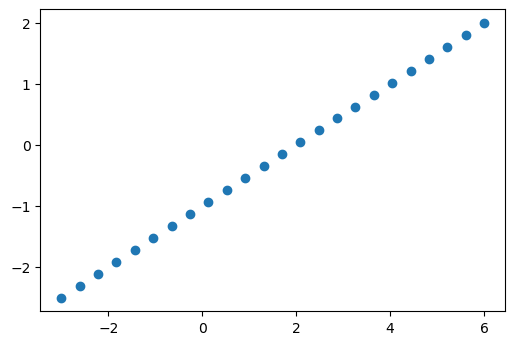

In [304]:
xleft = -3
xright = 6
n = 24
x = np.linspace(xleft,xright,n)
yf = np.zeros ((n))
y = np.zeros ((n))
yf = -1. + 0.5*x
plt.plot (x,yf, 'o')

### Зашумление данных

10.0


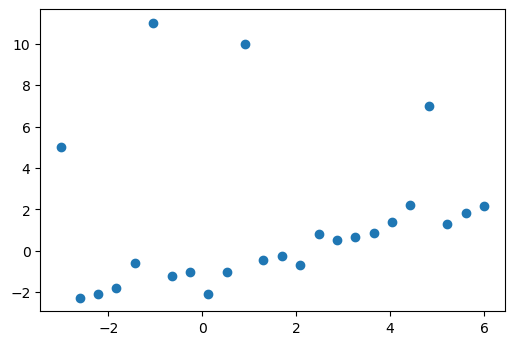

In [317]:
Delta = 0.5 * np.random.randn(len(x))
y = yf + Delta
y_av = np.sum(y)/len(x)

y [10] = 10.
y [20] = 7.
y [0] = 5.
y [5] = 11.


plt.plot (x, y, 'o')

print (y[10])

### Построение аппроксимационного полинома 

Коэффициенты [0.94306046 0.21158679]
Числа обусловленности матриц G и Phi 12.555026847787225 3.6332951102445272


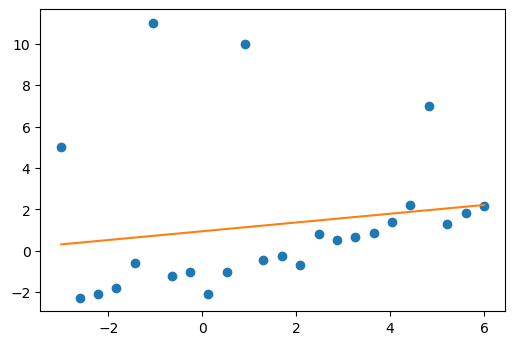

In [318]:
m = 1

PolynomCoefs = SqLeastReg(x, y, m, 1)
print ('Коэффициенты', PolynomCoefs)

cond = np.linalg.cond (G)
condPhi = np.linalg.cond (Phi)
EigG = np.linalg.eigvals (G)
print ('Числа обусловленности матриц G и Phi', cond, condPhi)

PolynomValue2 = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue2 += PolynomCoefs[i]*x**i
    
plt.plot (x, y, 'o')
plt.plot (x, PolynomValue2)

In [319]:
def SqLeastRegMy(x, y, m, alpha):
    global G, Phi
    
    n = len(x)
    
    Phi = np.zeros ((n,m+1))
    
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    
    PhiT = Phi.T
    
    G = PhiT @ Phi
    z = PhiT @ y
    a = np.linalg.solve(G, z)
    
    eps = 0.001
    
    for i in range(0, 10):
        
        a_i = a
        a = np.linalg.solve(G, z - alpha* np.sign(a_i))
        e = a - a_i
        epsit = (sum(e**2))**0.5/len(e)
        
        print ('iteration', i, a, np.sign(a), epsit)
        
        if (epsit <= eps):
            break
         
    return a

In [320]:
def r(pha, y):
    val = pha - y
    return abs(val)

In [321]:
def SqLeastRegMy1(x, y, m):
    global G, Phi
    
    n = len(x)
    
    Phi = np.zeros ((n,m+1))
    
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    
    PhiT = Phi.T
    
    a = np.linalg.solve(PhiT @ Phi, PhiT @ y)
    
    eps = 0.001
    
    for i in range(0, 10):
        
        a_i = a
        
        R = np.zeros((n, n))
        
        for j in range(0, n - 1):
            R[j, j] = r((Phi @ a_i)[j], y[j]) / ((Phi @ a_i)[j] - y[j])**2

        
        a = np.linalg.solve(PhiT @ R @ Phi, PhiT @ R @ y)
        e = a - a_i
        epsit = (sum(e**2))**0.5/len(e)
        
        print ('iteration', i, a, np.sign(a), epsit)
        
        if (epsit <= eps):
            break
         
    return a

iteration 0 [-0.17782232  0.38631136] [-1.  1.] 0.5922113030505374
iteration 1 [-0.32122093  0.41773413] [-1.  1.] 0.07340052972663151
iteration 2 [-0.53336799  0.45784331] [-1.  1.] 0.10795267684921737
iteration 3 [-0.71978412  0.4840101 ] [-1.  1.] 0.09412182627026802
iteration 4 [-0.83637776  0.4927224 ] [-1.  1.] 0.05845934644942919
iteration 5 [-0.88936988  0.4926438 ] [-1.  1.] 0.02649609199832363
iteration 6 [-0.89970544  0.49233431] [-1.  1.] 0.005170095621614481
iteration 7 [-0.90667313  0.49267261] [-1.  1.] 0.003487948142057046
iteration 8 [-0.91147058  0.49180581] [-1.  1.] 0.002437562480804775
iteration 9 [-0.9140549   0.49031711] [-1.  1.] 0.0014912203359045827
Коэффициенты [-0.9140549   0.49031711]
Числа обусловленности матриц G и Phi 12.555026847787225 3.6332951102445272


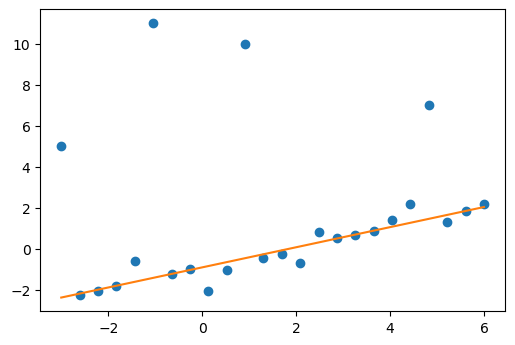

In [322]:
m = 1

PolynomCoefs = SqLeastRegMy1 (x, y, m)
print ('Коэффициенты', PolynomCoefs)

cond = np.linalg.cond (G)
EigG = np.linalg.eigvals (G)
print ('Числа обусловленности матриц G и Phi', cond, condPhi)

PolynomValue1 = np.zeros(len(x))
for i in range (0, m+1):
    PolynomValue1 += PolynomCoefs[i]*x**i
    
plt.plot (x, y, 'o')
plt.plot (x, PolynomValue1)

### Робастная аппроксимация

In [339]:
def r1(pha, y):
    val = pha - y
    #return abs(val)
    dist = 1
    
    v1 = val**2 
    v2 = -dist**2 + 2 * dist * abs(val)
    return v1 if abs(val) <= dist else v2

In [340]:
def SqLeastRobustMy(x, y, m):
    global G, Phi
    
    n = len(x)
    
    Phi = np.zeros ((n,m+1))
    
    for k in range (0, m+1):
        Phi[:,k] = BasicFunctions (k, x)
    
    PhiT = Phi.T
    
    a = np.linalg.solve(PhiT @ Phi, PhiT @ y)
    
    eps = 0.001
    
    for i in range(0, 10):
        
        a_i = a
        
        R = np.zeros((n, n))
        for j in range(0, n - 1):
            R[j, j] = r1((Phi @ a_i)[j], y[j]) / ((Phi @ a_i)[j] - y[j])**2
        
        a = np.linalg.solve(PhiT @ R @ Phi, PhiT @ R @ y)
        e = a - a_i
        epsit = (sum(e**2))**0.5/len(e)
        
        print ('iteration', i, a, np.sign(a), epsit)
        
        if (epsit <= eps):
            break
         
    return a

iteration 0 [-0.09174182  0.35146333] [-1.  1.] 0.547111932606542
iteration 1 [-0.3991146   0.42104901] [-1.  1.] 0.15757553307258476
iteration 2 [-0.4379259   0.43062098] [-1.  1.] 0.019987119870497807
iteration 3 [-0.44193228  0.43162329] [-1.  1.] 0.002064926853264272
iteration 4 [-0.44234413  0.4317273 ] [-1.  1.] 0.00021238710114187715
Коэффициенты [-0.44234413  0.4317273 ]
Числа обусловленности матриц G и Phi 12.555026847787225 3.6332951102445272


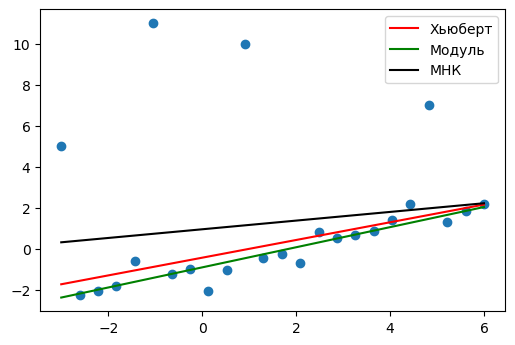

In [341]:
m = 1

PolynomCoefs = SqLeastRobustMy (x, y, m)
print ('Коэффициенты', PolynomCoefs)

cond = np.linalg.cond (G)
condPhi = np.linalg.cond (Phi)
EigG = np.linalg.eigvals (G)
print ('Числа обусловленности матриц G и Phi', cond, condPhi)

PolynomValue = np.zeros(len(x))

for i in range (0, m+1):
    PolynomValue += PolynomCoefs[i]*x**i
    
plt.plot (x, y, 'o')
plt.plot (x, PolynomValue, color="red", label='Хьюберт')
plt.plot (x, PolynomValue1, color="green", label='Модуль')
plt.plot (x, PolynomValue2, color="black", label='МНК')
plt.legend()